In [24]:
!pip install nltk scikit-learn numpy pandas -q


Importing the dependencies

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import re
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

Data loading & Understanding

In [26]:
df = pd.read_csv('movies.csv')
df.head()

,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew,director
0,0,237000000,Action Adventure Fantasy Science Fiction,http://www.avatarmovie.com/,19995,culture clash future space war space colony so...,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Sam Worthington Zoe Saldana Sigourney Weaver S...,"[{'name': 'Stephen E. Rivkin', 'gender': 0, 'd...",James Cameron
1,1,300000000,Adventure Fantasy Action,http://disney.go.com/disneypictures/pirates/,285,ocean drug abuse exotic island east india trad...,en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Johnny Depp Orlando Bloom Keira Knightley Stel...,"[{'name': 'Dariusz Wolski', 'gender': 2, 'depa...",Gore Verbinski
2,2,245000000,Action Adventure Crime,http://www.sonypictures.com/movies/spectre/,206647,spy based on novel secret agent sequel mi6,en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Daniel Craig Christoph Waltz L\u00e9a Seydoux ...,"[{'name': 'Thomas Newman', 'gender': 2, 'depar...",Sam Mendes
3,3,250000000,Action Crime Drama Thriller,http://www.thedarkknightrises.com/,49026,dc comics crime fighter terrorist secret ident...,en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,Christian Bale Michael Caine Gary Oldman Anne ...,"[{'name': 'Hans Zimmer', 'gender': 2, 'departm...",Christopher Nolan
4,4,260000000,Action Adventure Science Fiction,http://movies.disney.com/john-carter,49529,based on novel mars medallion space travel pri...,en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,Taylor Kitsch Lynn Collins Samantha Morton Wil...,"[{'name': 'Andrew Stanton', 'gender': 2, 'depa...",Andrew Stanton


Filtering required colums

In [27]:
required_columns = ['title', 'keywords','genres', 'overview']
df = df[required_columns]
df.head()

,title,keywords,genres,overview
0,Avatar,culture clash future space war space colony so...,Action Adventure Fantasy Science Fiction,"In the 22nd century, a paraplegic Marine is di..."
1,Pirates of the Caribbean: At World's End,ocean drug abuse exotic island east india trad...,Adventure Fantasy Action,"Captain Barbossa, long believed to be dead, ha..."
2,Spectre,spy based on novel secret agent sequel mi6,Action Adventure Crime,A cryptic message from Bond’s past sends him o...
3,The Dark Knight Rises,dc comics crime fighter terrorist secret ident...,Action Crime Drama Thriller,Following the death of District Attorney Harve...
4,John Carter,based on novel mars medallion space travel pri...,Action Adventure Science Fiction,"John Carter is a war-weary, former military ca..."


In [28]:
df.isnull().sum()

,0
title,0
keywords,412
genres,28
overview,3


In [29]:
df= df.dropna().reset_index(drop = True)
df.isnull().sum()

,0
title,0
keywords,0
genres,0
overview,0


In [30]:
df['combined'] = df['keywords'] + ' ' + df['genres'] + ' ' + df['overview']
df.head()

,title,keywords,genres,overview,combined
0,Avatar,culture clash future space war space colony so...,Action Adventure Fantasy Science Fiction,"In the 22nd century, a paraplegic Marine is di...",culture clash future space war space colony so...
1,Pirates of the Caribbean: At World's End,ocean drug abuse exotic island east india trad...,Adventure Fantasy Action,"Captain Barbossa, long believed to be dead, ha...",ocean drug abuse exotic island east india trad...
2,Spectre,spy based on novel secret agent sequel mi6,Action Adventure Crime,A cryptic message from Bond’s past sends him o...,spy based on novel secret agent sequel mi6 Act...
3,The Dark Knight Rises,dc comics crime fighter terrorist secret ident...,Action Crime Drama Thriller,Following the death of District Attorney Harve...,dc comics crime fighter terrorist secret ident...
4,John Carter,based on novel mars medallion space travel pri...,Action Adventure Science Fiction,"John Carter is a war-weary, former military ca...",based on novel mars medallion space travel pri...


In [31]:
data = df[['title', 'combined']]
data.head()

,title,combined
0,Avatar,culture clash future space war space colony so...
1,Pirates of the Caribbean: At World's End,ocean drug abuse exotic island east india trad...
2,Spectre,spy based on novel secret agent sequel mi6 Act...
3,The Dark Knight Rises,dc comics crime fighter terrorist secret ident...
4,John Carter,based on novel mars medallion space travel pri...


In [32]:
# WordCloud for movie content
combined_text = " ".join(df['combined'])
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(combined_text)

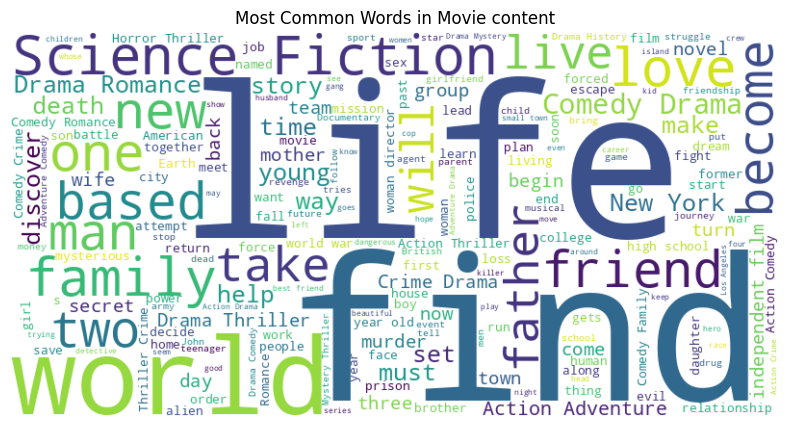

In [33]:
# WordCloud to visualize the most common words in the movie content
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Common Words in Movie content")
plt.show()

In [34]:
# download nltk data
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [35]:
stop_words = set(stopwords.words('english'))

In [36]:
ps = PorterStemmer()

In [37]:
def preprocess_text(text):
    # 1. Convert to lowercase
    text = text.lower()

    # 2. Remove non-alphabet characters using regex
    text = re.sub('[^a-z]', ' ', text)

    # 3. Tokenize the text
    tokens = word_tokenize(text)

    # 4. Remove stopwords and short words, apply stemming
    cleaned = [ps.stem(word) for word in tokens if word not in stop_words and len(word) > 2]

    # 5. Join the tokens back into one string
    return ' '.join(cleaned)

In [39]:
data.loc[:, 'cleaned_text'] = data['combined'].apply(preprocess_text)
data.head()

,title,combined,cleaned_text
0,Avatar,culture clash future space war space colony so...,cultur clash futur space war space coloni soci...
1,Pirates of the Caribbean: At World's End,ocean drug abuse exotic island east india trad...,ocean drug abus exot island east india trade c...
2,Spectre,spy based on novel secret agent sequel mi6 Act...,spi base novel secret agent sequel action adve...
3,The Dark Knight Rises,dc comics crime fighter terrorist secret ident...,comic crime fighter terrorist secret ident bur...
4,John Carter,based on novel mars medallion space travel pri...,base novel mar medallion space travel princess...


In [40]:
#Vectorization with TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf.fit_transform(data['cleaned_text'])

In [42]:
#compute cosine similarities
cosine_sim = cosine_similarity(tfidf_matrix,tfidf_matrix)

In [43]:
# Recommendation Function
def recommend_movies(movie_name, cosine_sim=cosine_sim, df=data, top_n=5):
    # Find the index of the movie
    idx = df[df['title'].str.lower() == movie_name.lower()].index
    if len(idx) == 0:
        return "Movie not found in the dataset!"
    idx = idx[0]

    # Get similarity scores
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]

    # Get movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return top n similar movies
    return df[['title']].iloc[movie_indices]

In [44]:
row_index = df[df['title'] == "Batman v Superman: Dawn of Justice"].index
print(row_index)

Index([9], dtype='int64')


In [45]:
movie_name = data["title"][9]
print(movie_name)

Batman v Superman: Dawn of Justice


In [46]:
# Example Recommendation
print(f"Recommendations for the Movie {movie_name}")
recommendations = recommend_movies(movie_name)
print(recommendations)

Recommendations for the Movie Batman v Superman: Dawn of Justice
             title
1685      Kick-Ass
14    Man of Steel
161       Watchmen
861    Superman II
3590      Defendor
